# Train Eval Baseline for CelebA Dataset
---

## Import Libraries

In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from disenn.datasets.celeba_dataset import CelebA

from disenn.models.conceptizers import VaeConceptizer
from disenn.models.parameterizers import ConvParameterizer
from disenn.models.aggregators import SumAggregator
from disenn.models.disenn import DiSENN

from disenn.models.losses import celeba_robustness_loss
from disenn.models.losses import BVAE_loss

## Load Data

In [3]:
celeba_dataset = CelebA(split='train', data_path='data/celeba')

In [4]:
train_dl = DataLoader(celeba_dataset, batch_size=10, shuffle=True)

In [5]:
x,y = next(iter(train_dl))

# $\beta$-VAE Conceptizer

## Forward Pass

In [6]:
conceptizer = VaeConceptizer(num_concepts=10)

In [7]:
concept_mean, concept_logvar, x_reconstruct = conceptizer(x)

In [8]:
x.shape

torch.Size([10, 3, 64, 64])

In [9]:
concept_mean.shape, concept_logvar.shape

(torch.Size([10, 10]), torch.Size([10, 10]))

In [10]:
x_reconstruct.shape

torch.Size([10, 3, 64, 64])

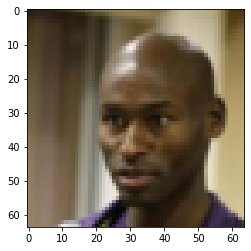

In [11]:
plt.imshow(x[0].numpy().transpose(1,2,0))

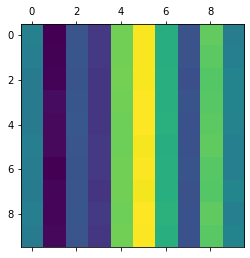

In [12]:
plt.matshow(concept_mean.detach().numpy())

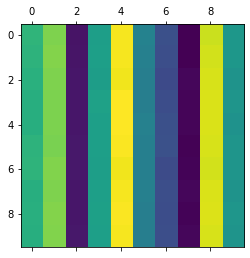

In [13]:
plt.matshow(concept_logvar.detach().numpy())

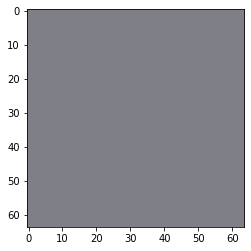

In [14]:
plt.imshow(x_reconstruct[0].detach().numpy().transpose(1,2,0))

## Training

In [15]:
optimizer = optim.Adam(conceptizer.parameters())
conceptizer.train()

VaeConceptizer(
  (encoder): ConvEncoder(
    (conv_block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (fc_block): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu_logvar_layer): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): ConvDecoder(
    (fc_block): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=5

In [16]:
EPOCHS = 1
BETA = 1
PRINT_FREQ = 100

In [18]:
for epoch in range(EPOCHS):
    for i, (x, _) in enumerate(train_dl):
        optimizer.zero_grad()
        x = x.float()
        concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
        recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
        loss = recon_loss + BETA * kl_div
        loss.backward()
        optimizer.step()
        if i % PRINT_FREQ == 0:
            print(f"EPOCH:{epoch} STEP:{i} \t"
                  f"Concept Loss: {loss:.3f} "
                  f"Recon Loss: {recon_loss:.3f} "
                  f"KL Div: {kl_div}")

EPOCH:0 STEP:0 	Concept Loss: 0.187 Recon Loss: 0.095 KL Div: 0.0923764705657959


KeyboardInterrupt: 

In [19]:
conceptizer.eval();

In [20]:
concept_mean, concept_logvar, x_reconstruct = conceptizer(x)

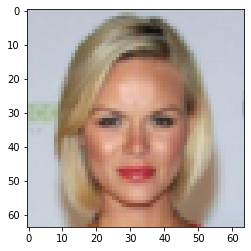

In [21]:
plt.imshow(x[2].numpy().transpose(1,2,0))

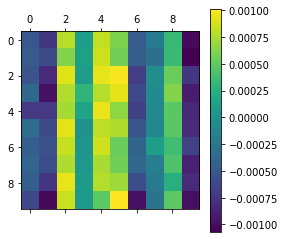

In [22]:
plt.matshow(concept_mean.detach().numpy())
plt.colorbar()

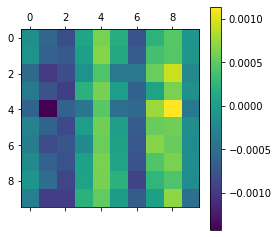

In [23]:
plt.matshow(concept_logvar.detach().numpy())
plt.colorbar()

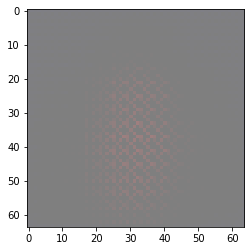

In [24]:
plt.imshow(x_reconstruct[9].detach().numpy().transpose(1,2,0))

# DiSENN

## Forward Pass

In [25]:
NUM_CONCEPTS = 10
NUM_CLASS = 2

In [26]:
conceptizer = VaeConceptizer(NUM_CONCEPTS)

In [27]:
parameterizer = ConvParameterizer(NUM_CONCEPTS, NUM_CLASS)

In [28]:
aggregator = SumAggregator(NUM_CLASS)

In [29]:
disenn = DiSENN(conceptizer, parameterizer, aggregator)

In [30]:
y_pred, explanation, x_construct = disenn(x)

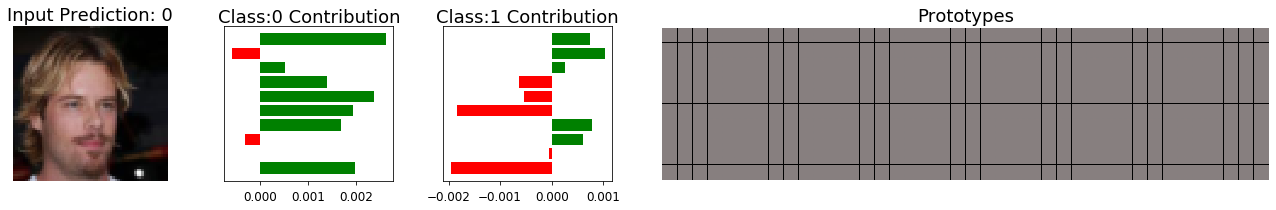

In [32]:
disenn.explain(x[0], 1, show=True, num_prototypes=40)

## Training

In [64]:
EPOCHS = 1
BETA = 1
ROBUST_REG = 1e-4
PRINT_FREQ = 5

In [65]:
opt = optim.Adam(disenn.parameters())
disenn.train();

In [67]:
for epoch in range(EPOCHS):
    for i, (x, labels) in enumerate(train_dl):
        x = x.float()
        labels = labels.long()
        opt.zero_grad()

        # track all operations on x for jacobian calculation
        x.requires_grad_(True)
        y_pred, (concepts_dist, relevances), x_reconstruct = disenn(x)

        concept_mean, concept_logvar = concepts_dist
        concepts = concept_mean

        pred_loss = F.nll_loss(y_pred.squeeze(-1), labels)
        robustness_loss = celeba_robustness_loss(x, y_pred, concepts, relevances)
        recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
        concept_loss = recon_loss + BETA * kl_div

        total_loss = pred_loss + concept_loss + (ROBUST_REG * robustness_loss) 
        total_loss.backward()
        opt.step()

        if i % PRINT_FREQ == 0:
            print(f"EPOCH:{epoch} STEP:{i} \t"
                  f"Loss: {total_loss:.3f} "
                  f"Pred Loss: {pred_loss:.3f} "
                  f"Robust Loss: {robustness_loss:.3f} "
                  f"Concept Loss: {concept_loss:.3f} "
                  f"Recon Loss: {recon_loss:.3f} "
                  f"KL Div: {kl_div:.5f}")

EPOCH:0 STEP:0 	Loss: 0.777 Pred Loss: 0.683 Robust Loss: 0.218 Concept Loss: 0.093 Recon Loss: 0.077 KL Div: 0.01672
EPOCH:0 STEP:5 	Loss: 0.652 Pred Loss: 0.547 Robust Loss: 0.103 Concept Loss: 0.105 Recon Loss: 0.073 KL Div: 0.03171
EPOCH:0 STEP:10 	Loss: 0.855 Pred Loss: 0.761 Robust Loss: 0.057 Concept Loss: 0.093 Recon Loss: 0.074 KL Div: 0.01891
EPOCH:0 STEP:15 	Loss: 0.789 Pred Loss: 0.677 Robust Loss: 0.032 Concept Loss: 0.112 Recon Loss: 0.095 KL Div: 0.01732
EPOCH:0 STEP:20 	Loss: 0.741 Pred Loss: 0.653 Robust Loss: 0.028 Concept Loss: 0.088 Recon Loss: 0.079 KL Div: 0.00914
EPOCH:0 STEP:25 	Loss: 0.726 Pred Loss: 0.627 Robust Loss: 0.022 Concept Loss: 0.099 Recon Loss: 0.095 KL Div: 0.00424
EPOCH:0 STEP:30 	Loss: 0.934 Pred Loss: 0.807 Robust Loss: 0.180 Concept Loss: 0.127 Recon Loss: 0.102 KL Div: 0.02474
EPOCH:0 STEP:35 	Loss: 0.681 Pred Loss: 0.604 Robust Loss: 0.146 Concept Loss: 0.077 Recon Loss: 0.072 KL Div: 0.00492
EPOCH:0 STEP:40 	Loss: 0.591 Pred Loss: 0.502 Robu

KeyboardInterrupt: 

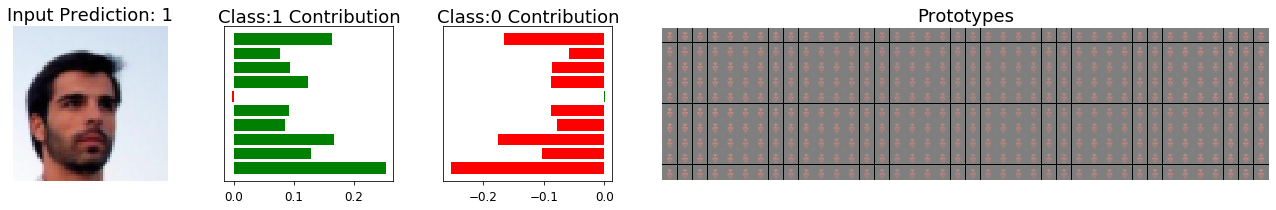

In [73]:
disenn.explain(x[5].detach(), 0, show=True, num_prototypes=40)